In [82]:
import pandas as pd
import numpy as np
import time
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import numpy as np
import math

In [56]:
standings_2025 = pd.read_csv('standings_2025_before_all_star.csv')
standings_2006_2024 = pd.read_csv('end_season_standings_2006_2024.csv')
standings_2006_2024_before_allstar = pd.read_csv('standings_2006_2024_before_all_star.csv')


In [57]:
#Adding more Attributes about each Team (home wins/losses, remaining games, Strength of Schedule Remaining etc)

standings_2025["home_wins"] = standings_2025['HOME'].str.rstrip('-').str[:2].astype(int)
standings_2025['home_losses'] = standings_2025['HOME'].str.rstrip('-').str[3:].astype(int)
standings_2025["away_wins"] = standings_2025['AWAY'].str.rstrip('-').str[:2].astype(int)
standings_2025['away_losses'] = standings_2025['AWAY'].str.rstrip('-').str[3:].astype(int)


standings_2025["home_games_remaining"] = 81 - standings_2025["home_wins"] - standings_2025["home_losses"]
standings_2025["away_games_remaining"] = 81 - standings_2025["away_wins"] - standings_2025["away_losses"]


standings_2025['SOS_remaining'] = [
    0.489,  # Detroit Tigers
    0.481,  # Los Angeles Dodgers
    0.482,  # Chicago Cubs
    0.479,  # Houston Astros
    0.511,  # Milwaukee Brewers
    0.497,  # Philadelphia Phillies
    0.503,  # Toronto Blue Jays
    0.511,  # New York Mets
    0.498,  # New York Yankees
    0.485,  # San Diego Padres
    0.509,  # Boston Red Sox
    0.488,  # San Francisco Giants
    0.487,  # Seattle Mariners
    0.500,  # St. Louis Cardinals
    0.521,  # Cincinnati Reds
    0.501,  # Tampa Bay Rays
    0.513,  # Texas Rangers
    0.504,  # Los Angeles Angels
    0.502,  # Minnesota Twins
    0.494,  # Arizona Diamondbacks
    0.498,  # Kansas City Royals
    0.480,  # Cleveland Guardians
    0.508,  # Miami Marlins
    0.515,  # Baltimore Orioles
    0.507,  # Atlanta Braves
    0.507,  # Athletics Athletics
    0.496,  # Pittsburgh Pirates
    0.503,  # Washington Nationals
    0.513,  # Chicago White Sox
    0.516   # Colorado Rockies
]


standings_2025['SOS_final'] = (((standings_2025['W']+ standings_2025['L']) * standings_2025['SOS']) + ((162-(standings_2025['W']+ standings_2025['L'])) * standings_2025['SOS_remaining']))/162
standings_2025['Pythag_Wins'] = (standings_2025['RS'] ** 1.83) / (standings_2025['RS'] ** 1.83 + standings_2025['RA'] ** 1.83) * (standings_2025['W']+ standings_2025['L'])
standings_2025['Win_Diff'] = standings_2025['W'] - standings_2025['Pythag_Wins']

standings_2025.columns = standings_2025.columns.map(lambda col: col + "_mid")


In [58]:
standings_2025 = standings_2025.rename(columns = {'SOS_final_mid': "SOS_final", 'home_games_remaining_mid': "home_games_remaining","away_games_remaining_mid": "away_games_remaining" })

In [65]:
#Adding the same attributes 

historical = pd.merge(standings_2006_2024_before_allstar,standings_2006_2024, on = ['TEAM', "Year"], how = 'inner', suffixes=('_mid', '_final'))
historical["Final_Wins"] = historical["W_final"]

historical["home_wins_mid"] = historical['HOME_mid'].str.rstrip('-').str[:2].astype(int)
historical['home_losses_mid'] = historical['HOME_mid'].str.rstrip('-').str[3:].astype(int)
historical['away_losses_mid'] = historical['AWAY_mid'].str.rstrip('-').str[3:].astype(int)
historical['away_wins_mid'] = historical['AWAY_mid'].apply(
    lambda x: int(x.split('-')[0]) if '-' in x else int(x))
historical["home_games_remaining"] = 81 - historical["home_wins_mid"] - historical["home_losses_mid"]
historical["away_games_remaining"] = 81 - historical["away_wins_mid"] - historical["away_losses_mid"]
historical['Pythag_Wins_mid'] = (historical['RS_mid'] ** 1.83) / (historical['RS_mid'] ** 1.83 + historical['RA_mid'] ** 1.83) * (historical['W_mid']+historical['L_mid'])
historical['Win_Diff_mid'] = historical['W_mid'] - historical['Pythag_Wins_mid']

In [67]:
#adding the features for the ML algorithm and running training and testing using Time Series Split 
#Looking at the Mean Absolute Error for Each Test Set

features = ['W_mid','RS_mid', 'RA_mid', 'DIFF_mid', 'SOS_final', 'Home_Win_PCT_mid',
            'Away_Win_PCT_mid', 'home_games_remaining', 'away_games_remaining',
            'Pythag_Wins_mid','Win_Diff_mid'
            ]
target = 'Final_Wins'
tscv = TimeSeriesSplit(n_splits=5)

# Optimized XGBoost model
model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)


train_data = historical
train_data = train_data.sort_values('Year')

tscv = TimeSeriesSplit(n_splits=5)


for train_index, test_index in tscv.split(train_data):
    train_years = np.unique(train_data.iloc[train_index]['Year'])
    test_years = np.unique(train_data.iloc[test_index]['Year'])
    print(f"Training Years: {min(train_years)}-{max(train_years)} ({len(train_years)} seasons)")
    print(f"Testing Years: {min(test_years)}-{max(test_years)} ({len(test_years)} seasons)")
    X_train, X_test = train_data.iloc[train_index][features], train_data.iloc[test_index][features]
    y_train, y_test = train_data.iloc[train_index][target], train_data.iloc[test_index][target]
    
    model.fit(X_train, y_train)
    val_preds = model.predict(X_test)
    val_mae = mean_absolute_error(y_test, val_preds)
    print(f"Fold MAE: {val_mae:.2f}")

Training Years: 2006-2008 (3 seasons)
Testing Years: 2009-2011 (3 seasons)
Fold MAE: 5.26
Training Years: 2006-2011 (6 seasons)
Testing Years: 2012-2014 (3 seasons)
Fold MAE: 4.93
Training Years: 2006-2014 (9 seasons)
Testing Years: 2015-2017 (3 seasons)
Fold MAE: 4.58
Training Years: 2006-2017 (12 seasons)
Testing Years: 2018-2021 (3 seasons)
Fold MAE: 5.88
Training Years: 2006-2021 (15 seasons)
Testing Years: 2022-2024 (3 seasons)
Fold MAE: 4.57


In [68]:
#Projected Standings based on my Model

X_2025 = standings_2025[features]
standings_2025['Projected_Final_Wins'] = model.predict(X_2025)
standings_2025["Win_Range"] = [f"{round(wins-5), round(wins+5)}" for wins in standings_2025['Projected_Final_Wins']]
projected_standings = standings_2025[['TEAM_mid', 'Projected_Final_Wins', "Win_Range"]]
projected_standings = projected_standings.rename(columns = {'TEAM_mid': "Team"}).sort_values('Projected_Final_Wins', ascending = False)
projected_standings['Projected_Final_Wins'] = projected_standings['Projected_Final_Wins'].round()
projected_standings

,Team,Projected_Final_Wins,Win_Range
0,Detroit Tigers,98.0,"(93, 103)"
2,Chicago Cubs,98.0,"(93, 103)"
4,Milwaukee Brewers,97.0,"(92, 102)"
1,Los Angeles Dodgers,96.0,"(91, 101)"
3,Houston Astros,95.0,"(90, 100)"
5,Philadelphia Phillies,95.0,"(90, 100)"
8,New York Yankees,94.0,"(89, 99)"
7,New York Mets,91.0,"(86, 96)"
6,Toronto Blue Jays,90.0,"(85, 95)"
16,Texas Rangers,89.0,"(84, 94)"


In [69]:
#Fangraphs Projected Final Standings

data = {
    "Team": [
        "Los Angeles Angels", "Houston Astros", "Athletics Athletics", "Toronto Blue Jays",
        "Atlanta Braves", "Milwaukee Brewers", "St. Louis Cardinals", "Chicago Cubs",
        "Arizona Diamondbacks", "Los Angeles Dodgers", "San Francisco Giants",
        "Cleveland Guardians", "Seattle Mariners", "Miami Marlins", "New York Mets",
        "Washington Nationals", "Baltimore Orioles", "San Diego Padres", "Philadelphia Phillies",
        "Pittsburgh Pirates", "Texas Rangers", "Tampa Bay Rays", "Boston Red Sox",
        "Cincinnati Reds", "Colorado Rockies", "Kansas City Royals", "Detroit Tigers",
        "Minnesota Twins", "Chicago White Sox", "New York Yankees"
    ],
    "Fangraphs_Win_Projections": [
        76, 91, 70, 91, 
        77, 92, 82, 91,
        80, 94, 84, 80,
        87, 76, 91, 68,
        75, 85, 91, 70,
        83, 83, 84, 81,
        50, 79, 90, 80,
        61, 89
    ]
}
fangraphs_mapping_full = pd.DataFrame(data)

In [71]:
#Comparing Fangraphs and My Models Final Standings

myprojections_vs_fangraphs = pd.merge(projected_standings, fangraphs_mapping_full, on = 'Team', how = 'left')
myprojections_vs_fangraphs['Difference'] = myprojections_vs_fangraphs['Projected_Final_Wins'] - myprojections_vs_fangraphs['Fangraphs_Win_Projections'] 
myprojections_vs_fangraphs

,Team,Projected_Final_Wins,Win_Range,Fangraphs_Win_Projections,Difference
0,Detroit Tigers,98.0,"(93, 103)",90,8.0
1,Chicago Cubs,98.0,"(93, 103)",91,7.0
2,Milwaukee Brewers,97.0,"(92, 102)",92,5.0
3,Los Angeles Dodgers,96.0,"(91, 101)",94,2.0
4,Houston Astros,95.0,"(90, 100)",91,4.0
5,Philadelphia Phillies,95.0,"(90, 100)",91,4.0
6,New York Yankees,94.0,"(89, 99)",89,5.0
7,New York Mets,91.0,"(86, 96)",91,0.0
8,Toronto Blue Jays,90.0,"(85, 95)",91,-1.0
9,Texas Rangers,89.0,"(84, 94)",83,6.0


In [157]:
division_map = {
    'Toronto Blue Jays': 'AL East',
    'New York Yankees': 'AL East',
    'Baltimore Orioles': 'AL East',
    'Tampa Bay Rays': 'AL East',
    'Boston Red Sox': 'AL East',

    'Detroit Tigers': 'AL Central',
    'Cleveland Guardians': 'AL Central',
    'Kansas City Royals': 'AL Central',
    'Chicago White Sox': 'AL Central',
    'Minnesota Twins': 'AL Central',

    'Houston Astros': 'AL West',
    'Texas Rangers': 'AL West',
    'Seattle Mariners': 'AL West',
    'Los Angeles Angels': 'AL West',
    'Athletics Athletics': 'AL West',

    'Atlanta Braves': 'NL East',
    'Philadelphia Phillies': 'NL East',
    'New York Mets': 'NL East',
    'Miami Marlins': 'NL East',
    'Washington Nationals': 'NL East',

    'Chicago Cubs': 'NL Central',
    'St. Louis Cardinals': 'NL Central',
    'Milwaukee Brewers': 'NL Central',
    'Cincinnati Reds': 'NL Central',
    'Pittsburgh Pirates': 'NL Central',

    'Los Angeles Dodgers': 'NL West',
    'San Francisco Giants': 'NL West',
    'San Diego Padres': 'NL West',
    'Arizona Diamondbacks': 'NL West',
    'Colorado Rockies': 'NL West'
}

team_abbreviations = {
    "Detroit Tigers": "DET",
    "Los Angeles Dodgers": "LAD",
    "Chicago Cubs": "CHC",
    "Houston Astros": "HOU",
    "Milwaukee Brewers": "MIL",
    "Philadelphia Phillies": "PHI",
    "Toronto Blue Jays": "TOR",
    "New York Mets": "NYM",
    "New York Yankees": "NYY",
    "San Diego Padres": "SDP",
    "Boston Red Sox": "BOS",
    "San Francisco Giants": "SFG",
    "Seattle Mariners": "SEA",
    "St. Louis Cardinals": "STL",
    "Cincinnati Reds": "CIN",
    "Tampa Bay Rays": "TBR",
    "Texas Rangers": "TEX",
    "Los Angeles Angels": "LAA",
    "Minnesota Twins": "MIN",
    "Arizona Diamondbacks": "ARI",
    "Kansas City Royals": "KCR",
    "Cleveland Guardians": "CLE",
    "Miami Marlins": "MIA",
    "Baltimore Orioles": "BAL",
    "Atlanta Braves": "ATL",
    "Athletics Athletics": "OAK",  # Fix name if needed
    "Pittsburgh Pirates": "PIT",
    "Washington Nationals": "WSN",
    "Chicago White Sox": "CHW",
    "Colorado Rockies": "COL"
}

myprojections_vs_fangraphs['Division'] = myprojections_vs_fangraphs['Team'].map(division_map)
myprojections_vs_fangraphs['Team_Abb'] = myprojections_vs_fangraphs['Team'].map(team_abbreviations)

In [ ]:
AL_East = myprojections_vs_fangraphs[myprojections_vs_fangraphs['Division'] == 'AL East']
AL_Central = myprojections_vs_fangraphs[myprojections_vs_fangraphs['Division'] == 'AL Central']
AL_West = myprojections_vs_fangraphs[myprojections_vs_fangraphs['Division'] == 'AL West']
NL_East = myprojections_vs_fangraphs[myprojections_vs_fangraphs['Division'] == 'NL East']
NL_Central = myprojections_vs_fangraphs[myprojections_vs_fangraphs['Division'] == 'NL Central']
NL_West = myprojections_vs_fangraphs[myprojections_vs_fangraphs['Division'] == 'NL West']

,Team,Projected_Final_Wins,Win_Range,Fangraphs_Win_Projections,Difference,Division,Team_Abb
4,Houston Astros,95.0,"(90, 100)",91,4.0,AL West,HOU
9,Texas Rangers,89.0,"(84, 94)",83,6.0,AL West,TEX
11,Seattle Mariners,87.0,"(82, 92)",87,0.0,AL West,SEA
21,Los Angeles Angels,77.0,"(72, 82)",76,1.0,AL West,LAA
26,Athletics Athletics,69.0,"(64, 74)",70,-1.0,AL West,OAK


Text(0.0, 0.5, 'Projected Wins')

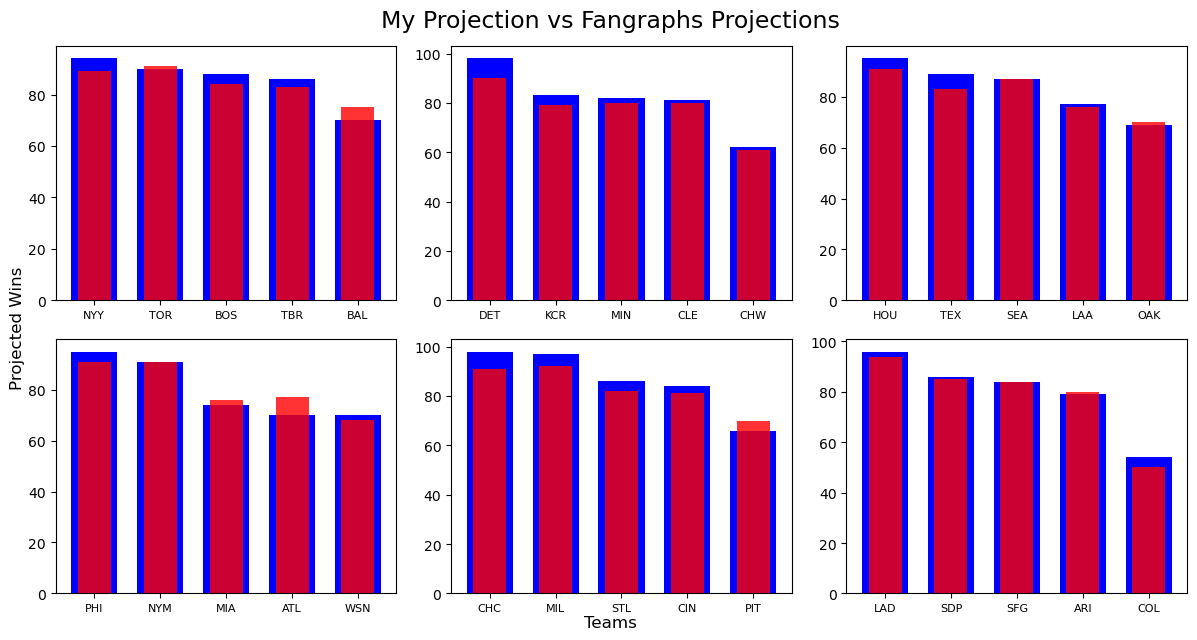

In [159]:
fig, axis = plt.subplots(2, 3, figsize=(12, 6))
plt.tight_layout(pad=1.0)
axis[0,0].bar(AL_East['Team_Abb'], AL_East['Projected_Final_Wins'], color = 'b', width = 0.7)
axis[0,0].bar(AL_East['Team_Abb'], AL_East['Fangraphs_Win_Projections'],  width = 0.5, alpha = 0.8, color = 'red')

axis[0,1].bar(AL_Central['Team_Abb'], AL_Central['Projected_Final_Wins'], color = 'b',width = 0.7)
axis[0,1].bar(AL_Central['Team_Abb'], AL_Central['Fangraphs_Win_Projections'],  width = 0.5, alpha = 0.8, color = 'red')

axis[0,2].bar(AL_West['Team_Abb'], AL_West['Projected_Final_Wins'], color = 'b',width = 0.7)
axis[0,2].bar(AL_West['Team_Abb'], AL_West['Fangraphs_Win_Projections'],  width = 0.5, alpha = 0.8, color = 'red')

axis[1,0].bar(NL_East['Team_Abb'], NL_East['Projected_Final_Wins'], color = 'b',width = 0.7)
axis[1,0].bar(NL_East['Team_Abb'], NL_East['Fangraphs_Win_Projections'],  width = 0.5, alpha = 0.8, color = 'red')

axis[1,1].bar(NL_Central['Team_Abb'], NL_Central['Projected_Final_Wins'], color = 'b',width = 0.7)
axis[1,1].bar(NL_Central['Team_Abb'], NL_Central['Fangraphs_Win_Projections'],  width = 0.5, alpha = 0.8, color = 'red')

axis[1,2].bar(NL_West['Team_Abb'], NL_West['Projected_Final_Wins'], color = 'b',width = 0.7)
axis[1,2].bar(NL_West['Team_Abb'], NL_West['Fangraphs_Win_Projections'],  width = 0.5, alpha = 0.8, color = 'red')

fig.text(0.5,1, 'My Projection vs Fangraphs Projections',ha='center',fontsize= 17)
fig.text(0.5, 0.00, 'Teams', ha='center', fontsize=12)
fig.text(0.00, 0.5, 'Projected Wins', va='center', rotation='vertical', fontsize=12)